# Chapter 4

In [1]:
123

[1] 123

In [22]:
library(rethinking)
data(Howell1)
d <- Howell1

#### 4E1

likelyhood is

$$y_i \thicksim Normal(\mu, \sigma)$$

#### 4E2


Two - same as the priors

#### 4E3

$$Pr(\mu, \sigma|y) = \frac {\prod_i {Normal(y_i|\mu,\sigma)Normal(\mu|0,10)Uniform(\sigma|0,50)}} 
{\int\int \prod_i {Normal(y_i|\mu,\sigma)Normal(\mu|0,10)Uniform(\sigma|0,50)}d\mu d\sigma}$$


#### 4E4

$$\mu_i = \alpha + \beta x_i$$

#### 4E5

Three, just like the number of priors


#### 4M1

$$y_i \thicksim Normal(\mu, \sigma)$$

$$\mu \thicksim Normal(0,10)$$

$$\sigma \thicksim Uniform(0,10)$$

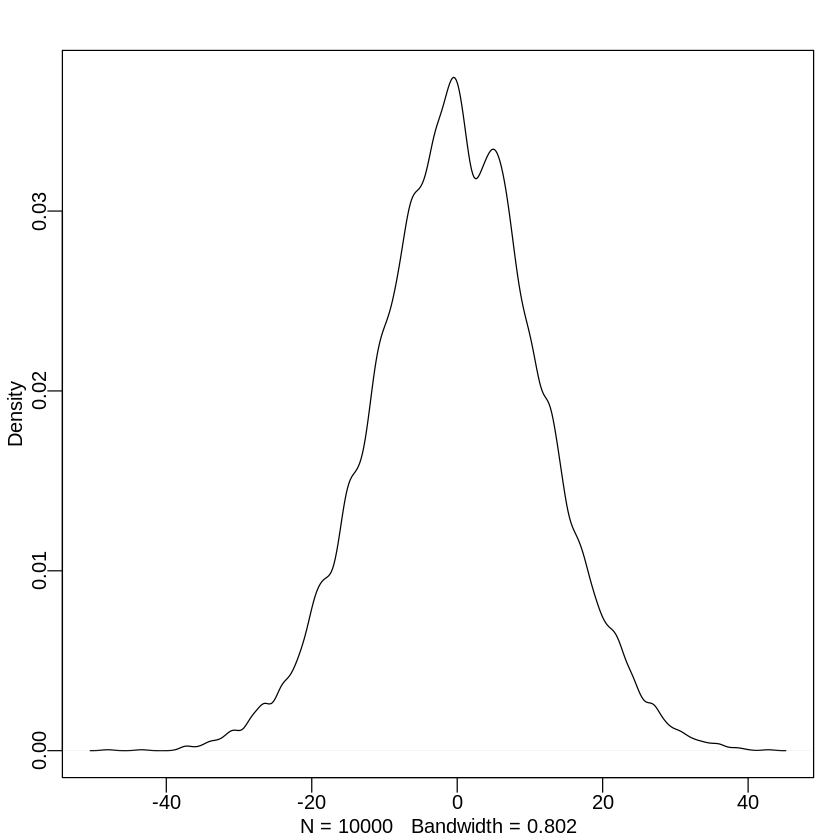

In [23]:
sample_mu <- rnorm(1e4, 0, 10)
sample_sigma <- runif(1e4, 0, 10)
prior_h <- rnorm(1e4, sample_mu, sample_sigma)
dens(prior_h)

## 4M2

In [24]:
flist <- alist(
  y ~ dnorm(mu, sigma),
  mu ~ dnorm(0,10),
  sigma ~ dunif(0,10)
)

## 4M3

$$y_i \thicksim Normal(\mu, \sigma)$$

$$\mu = \alpha + \beta * x_i$$

$$\alpha \thicksim Normal(0,50)$$

$$\beta \thicksim Uniform(0,10)$$

$$\sigma \thicksim Uniform(0,50)$$

## 4M4

$$height_i \thicksim Normal(\mu_i, \sigma)$$

$$\mu = \alpha +\beta year_i$$

$$\alpha \thicksim Normal(150,80)$$

For it to be meaningful to do such a study I assume students are not fully grown to begin with.

Allow the intercept to swing wildly.

$$\beta \thicksim Normal(10, 7)$$
Rather conservative prior (95% conf int between -4 to +24 cm / year), but want to keep "0" in the interval.


$$\sigma \thicksim Uniform(0,80)$$
It is reasonable to suspect that 95% of the sample are within 80 cm of length



## 4M5

$$\alpha \thicksim Normal(120, 80)$$
$$\beta \thicksim Normal(10,5)$$


## 4M6

$$\sigma \thicksim Uniform(0,64)$$

## 4H1

Make a regression weight ~ height and calculate height and HPDI from this


$$h_i \thicksim Normal(\mu_i, \sigma)$$
$$\mu_i = \alpha + \beta * x_i$$
$$\alpha \thicksim Normal(178, 100)$$
$$\beta \thicksim Normal(0, 10)$$
$$\sigma \thicksim Normal(0, 50)$$

In [25]:
d2 <- d[d$age >= 18,]
d2$weight.c <- d2$weight - mean(d2$weight)
m4H1 <- map2stan(alist(
  height ~ dnorm(mu, sigma),
  mu <- a + b*weight.c,
  a ~ dnorm(178,100),
  b ~ dnorm(0,10),
  sigma ~ dunif(0,50)
), data = d2)

Will attempt to remove dots internally.
recompiling to avoid crashing R session


In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file182bd71995.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is t

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 1000 / 1000 ]


In [26]:
stancode(m4H1)

data{
    int<lower=1> N;
    real height[N];
    real weight_c[N];
}
parameters{
    real a;
    real b;
    real<lower=0,upper=50> sigma;
}
model{
    vector[N] mu;
    // sigma ~ uniform( 0 , 50 );
    b ~ normal( 0 , 10 );
    a ~ normal( 178 , 100 );
    for ( i in 1:N ) {
        mu[i] = a + b * weight_c[i];
    }
    height ~ normal( mu , sigma );
}
generated quantities{
    vector[N] mu;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        mu[i] = a + b * weight_c[i];
    }
    dev = dev + (-2)*normal_lpdf( height | mu , sigma );
}


In [29]:
precis(m4H1, corr=TRUE)
mean(d2$height)

        Mean StdDev lower 0.89 upper 0.89 n_eff Rhat  1  2  3
a     154.58   0.27     154.09     154.97  1000    1  1 NA NA
b       0.91   0.04       0.84       0.97  1000    1 NA  1 NA
sigma   5.10   0.19       4.77       5.37  1000    1 NA NA  1

[1] 154.5971

In [ ]:
plot(height ~ weight.c, data = d2)
abline(a = coef(m4H1)["a"], b = coef(m4H1)["b"])

In [8]:
weights_4H1 <- c(46.95, 43.72, 64.78, 32.59, 54.63) - mean(d2$weight)
mu <- link(m4H1, data = data.frame(weight.c = weights_4H1))
mu.mean <- apply(mu, 2, mean)
mu.HPDI <- apply(mu, 2, HPDI, prob = 0.89)
mu.mean

[ 1000 / 1000 ]


[1] 156.3541 153.4429 172.4245 143.4113 163.2762

In [9]:
mu.HPDI

|0.89,155.8952,152.9924,171.1883,142.4667,162.5627
0.89|,156.7891,153.8654,173.8940,144.3419,164.0930


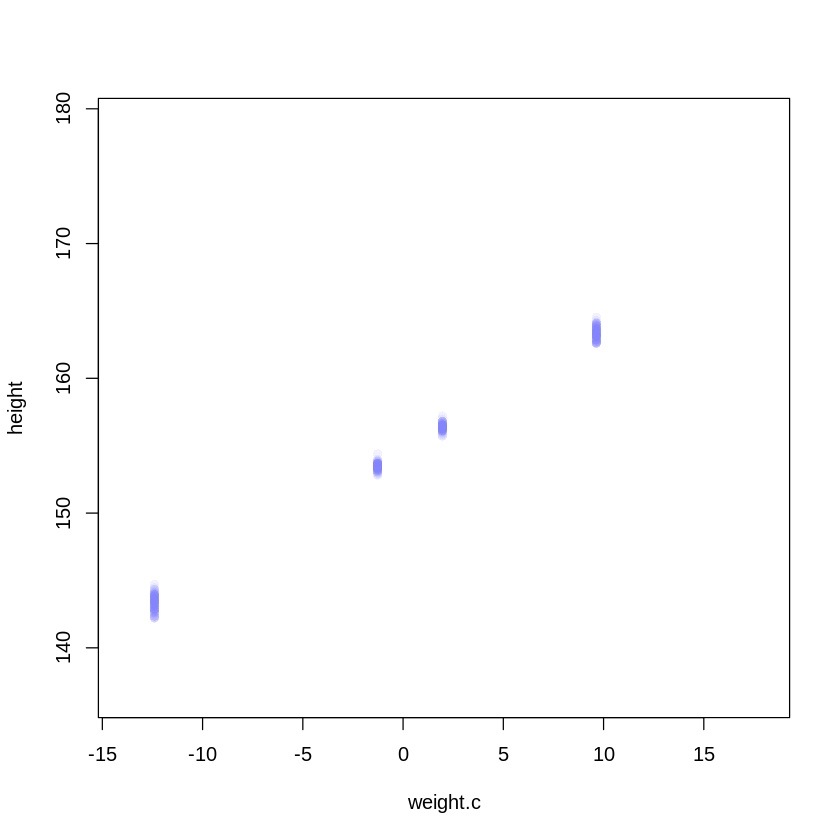

In [10]:
plot(height ~ weight.c, d2, type = "n")
for (i in 1:100)
  points(weights_4H1, mu[i,], pch = 16, col = col.alpha(rangi2, 0.1))

In [11]:
#### 4H2

Will attempt to remove dots internally.


In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file18a402b5.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is the

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 1000 / 1000 ]


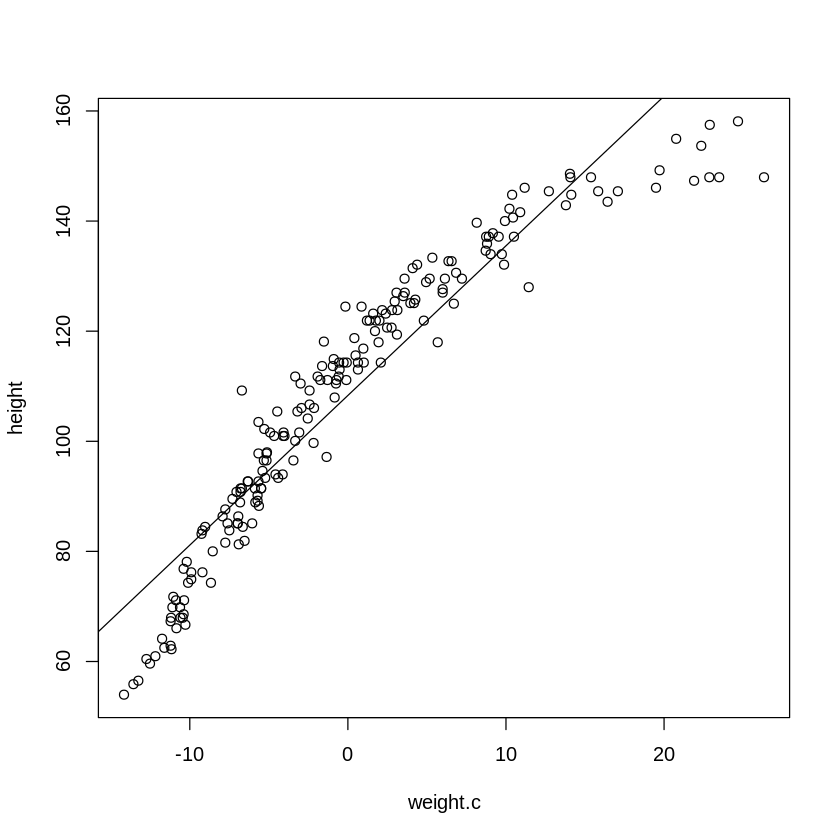

In [12]:
d3 <- d[d$age < 18,]

d3$weight.c <- d3$weight - mean(d3$weight)
m4H2 <- map(alist(
  height ~ dnorm(mu, sigma),
  mu <- a + b*weight.c,
  a ~ dnorm(150,100),
  b ~ dnorm(0,10),
  sigma ~ dunif(0,50)
), data = d3)

plot(height ~ weight.c, data = d3)
abline(a = coef(m4H2)["a"], b = coef(m4H2)["b"])

## 4H3

In [20]:
m4H3 <- map2stan(alist(
  height ~ dnorm(mu, sigma),
  mu <- a + b* log(weight),
  a ~ dnorm(178,100),
  b ~ dnorm(0,100),
  sigma ~ dunif(0,50)
), data = d)


In file included from /opt/conda/lib/R/library/BH/include/boost/config.hpp:39:0,
                 from /opt/conda/lib/R/library/BH/include/boost/math/tools/config.hpp:13,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/stan/math.hpp:4,
                 from /opt/conda/lib/R/library/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file186165158a.cpp:8:
/opt/conda/lib/R/library/BH/include/boost/config/compiler/gcc.hpp:186:0: warning: "BOOST_NO_CXX11_RVALUE_REFERENCES" redefined
 #  define BOOST_NO_CXX11_RVALUE_REFERENCES
 ^
<command-line>:0:0: note: this is t

Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Computing WAIC
Constructing posterior predictions


[ 1000 / 1000 ]


In [ ]:
weights.seq <- seq(from = 1, to = 70, by = 1)

mu <- link(m4H3, data = data.frame(weight = weights.seq))
mu.mean <- apply(mu, 2, mean)
mu.HPDI <- apply(mu, 2, HPDI, prob = 0.89)
mu.mean

In [ ]:
m4H3

In [ ]:
plot(height ~ weight, data = d, col = col.alpha(rangi2, 0.4))
lines(weights.seq, mu.mean)
shade(mu.HPDI, weights.seq)

In [19]:
stancode(m4H3)

data{
    int<lower=1> N;
    real height[N];
    real weight[N];
}
parameters{
    real a;
    real b;
    real<lower=0,upper=50> sigma;
}
model{
    vector[N] mu;
    // sigma ~ uniform( 0 , 50 );
    b ~ normal( 0 , 100 );
    a ~ normal( 178 , 100 );
    for ( i in 1:N ) {
        mu[i] = a + b * log(weight[i]);
    }
    height ~ normal( mu , sigma );
}
generated quantities{
    vector[N] mu;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        mu[i] = a + b * log(weight[i]);
    }
    dev = dev + (-2)*normal_lpdf( height | mu , sigma );
}


In [21]:
stancode(m4H3)

data{
    int<lower=1> N;
    real height[N];
    real weight[N];
}
parameters{
    real a;
    real b;
    real<lower=0,upper=50> sigma;
}
model{
    vector[N] mu;
    // sigma ~ uniform( 0 , 50 );
    b ~ normal( 0 , 100 );
    a ~ normal( 178 , 100 );
    for ( i in 1:N ) {
        mu[i] = a + b * log(weight[i]);
    }
    height ~ normal( mu , sigma );
}
generated quantities{
    vector[N] mu;
    real dev;
    dev = 0;
    for ( i in 1:N ) {
        mu[i] = a + b * log(weight[i]);
    }
    dev = dev + (-2)*normal_lpdf( height | mu , sigma );
}
